# EDA and creation of a dataframe

- **Assumptions:** 
    - Starting from "Most important data" 
    - Focused on Participant 1 
    - Focused on knee pain
    - Dropped via ferrata and swimming, which don't seem to provide much information
    - Dropped mean denivelation that has two long chunks of constant values
    - Activity of the day when the pain occurs is relevant (i.e. it contributes to the emergence of the pain)
    - For how the model is structured right now we are throwing away consecutive pairs of days with no pain
    
    
- **Steps for dataframe creation and preliminary investigation:**
    - Identified days when the the pain level increased by at least 2 in absolute value
    - Identified days when the pain level decreases
    - Identified "best" pain peak distance
    - Created dataframe with information on the day of the emergence of the pain and the previous day
    - Created dataframe with information on two consecutive days with no pain (days right before a pain event are excluded and the first two days after a pain event recedes are excluded as well)
    - Combined everything into a single dataframe with a "No-pain" and "Pain" label
    - Quick modeling test with random forest to take a look at feature importance
    - Implemented some minor optimization using SMOTE and hyperparameter optimization (note: SMOTE seems to not give the expected result)
    
    
- **Alternative approaches to look into:**
    - Look at change in relative pain
    - Consider more days after the pain stops as non-pain entries (i.e. do not remove days right after the pain level drops)
    - Consider consecutive "No Pain" periods and the possibility of "repeating" no pain days to obtain more pairs
    - Include increases of 1 in absolute pain
    - Include mean denivelation but remove periods of missing data
    - Test trivial predictors
    - Try not taking into account today's stressors: maybe recorded in the morning

***
# Questions

- Is the pain event recorded at the end of the day? Does it usually happen after some physical activity? Do we think that it is more associated to what is done that day or previous days? Essentially is today's physical activity relevant or should only the previous day be relevant?
- Mean denivelation has long periods of constant value, we drop this for now
- Via ferrata and swimming are essentially always zero so it might be good to drop them for now
- At later dates fewer pain jumps: do we need to take this into account

***
# Suggestions

- Count for number of pain spikes in a certain timeframe 
- Try removing data from day of pain
- Try ways to add mean denivelation
- Combine via ferrata with climbing

***
# Imports

In [32]:
import pickle
from functools import wraps
from datetime import datetime

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

mpl.rc('axes',labelsize=35)
mpl.rc('xtick',labelsize=30)
mpl.rc('ytick',labelsize=30)

import seaborn as sns
sns.set_context("poster")
sns.set(font_scale=3)
sns.set_style("whitegrid")

import pandas as pd
pd.set_option("display.max_rows", 10)
pd.set_option("display.max_columns", 10)

***
# Functions

In [33]:
def dataf_size_log(func):
    @wraps(func)
    def wrapper(dataf,*args,**kwargs):
        result = func(dataf,*args,**kwargs)
        print(f'{func.__name__} returns a {result.shape} dataframe')
        return result
    return wrapper

def load_data(datafolder,filename):
    input = open(datafolder+filename, "rb")
    data = pickle.load(input)
    input.close()
    return data

@dataf_size_log
def start_pipeline(dataf):
    return dataf.copy()

@dataf_size_log
def set_column_type(dataf):
    dataf = (dataf
             .assign(surfing=lambda x:x['surfing'].astype('int32'),
                     climbing=lambda x:x['climbing'].astype('int32'),
                     viaFerrata=lambda x:x['viaFerrata'].astype('int32'),
                     swimming=lambda x:x['swimming'].astype('int32'),
                     cycling=lambda x:x['cycling'].astype('int32')
                    )
            )
    return dataf

@dataf_size_log
def select_pain(dataf,pain):
    ps = ['kneePain','fingerHandArmPain', 'shoulderNeckPain', 'foreheadEyesPain']
    pains_to_drop = [p for p in ps if p!=pain]
    dataf = (dataf
             .drop(pains_to_drop,axis=1)
            )
    return dataf

def perc_of_non_zero(dataf):
    row_format="{:<40}" * 2
    for col in dataf.columns:
        print(row_format.format(col,round(100*(dataf[col]!=0).sum()/dataf.shape[0],2)))

def perc_unique_values(dataf):
    floatcols = dataf.select_dtypes(include=['float64'])
    row_format ="{:<40}" * 2
    for col in floatcols.columns:
        print(row_format.format(col,(floatcols[col].nunique())/dataf.shape[0]))
    

***
# Data Import

Here we also select the pain type that we are interested in. For now we will look at the knee pain one.

In [34]:
datafolder = '../data/preprocessed/'
filename = 'preprocessedMostImportantDataParticipant1.txt'
pain = 'kneePain'

In [35]:
data = load_data(datafolder,filename)

In [36]:
data['generalmood'].unique()

array([5.77164439, 7.        , 5.        , 3.        , 6.        ,
       4.        , 0.        , 2.        , 8.        , 1.        ])

In [37]:
part1 = (data
         .pipe(start_pipeline)
         .pipe(set_column_type)
         .pipe(select_pain,pain)
         .assign(pain_pct_change=lambda x:x['kneePain'].pct_change(),
                 pain_change=lambda x:x['kneePain'].diff()
                )
         .rename(columns=str.lower)
        )

start_pipeline returns a (1825, 21) dataframe
set_column_type returns a (1825, 21) dataframe
select_pain returns a (1825, 18) dataframe


In [8]:
part1.columns

Index(['tracker_mean_distance', 'tracker_mean_denivelation',
       'whatpulset_corrected', 'manictimedelta_corrected', 'timedrivingcar',
       'climbingdenivelation', 'climbingmaxeffortintensity',
       'climbingmeaneffortintensity', 'swimmingkm', 'surfing', 'climbing',
       'viaferrata', 'swimming', 'cycling', 'generalmood', 'scooterriding',
       'kneepain', 'sick_tired', 'pain_pct_change', 'pain_change'],
      dtype='object')

**Is sick tired supposed to be a target?**

***
# Data Exploration

In [349]:
part1['kneepain'].unique()

array([10.,  8.,  4.,  2.,  7.,  1.])

<AxesSubplot:>

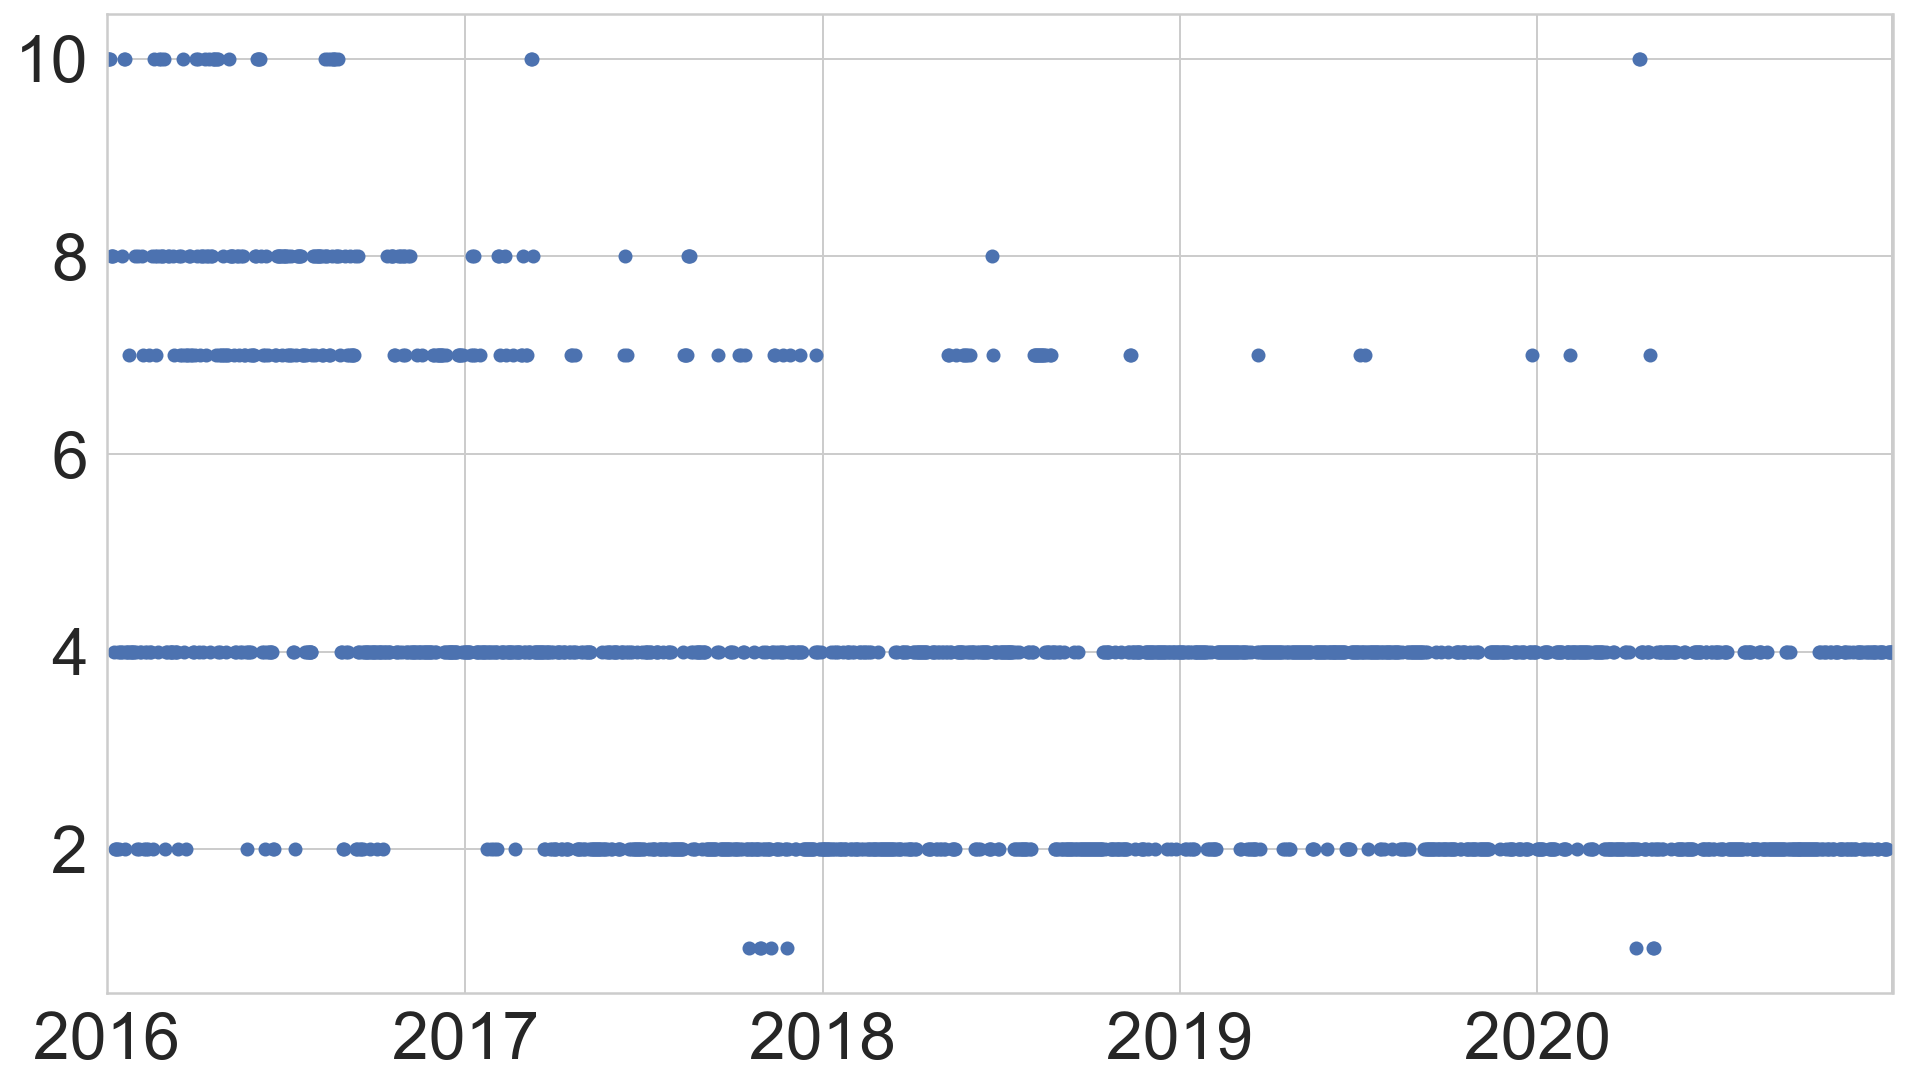

In [350]:
part1['kneepain'].plot(linestyle='',
                       marker='o'
                      )

It's unclear what happened to this data?

We create two columns that contain information on the change in the pain level for participant 1. One identifies the percentage of change and the other the absolute variation from the previous day.

In [351]:
part1[['kneepain','pain_change','pain_pct_change']].head(10)

,kneepain,pain_change,pain_pct_change
2016-01-01,10.0,NaN,NaN
2016-01-02,10.0,0.0,0.0
2016-01-03,10.0,0.0,0.0
2016-01-04,10.0,0.0,0.0
2016-01-05,8.0,-2.0,-0.2
2016-01-06,8.0,0.0,0.0
2016-01-07,8.0,0.0,0.0
2016-01-08,4.0,-4.0,-0.5
2016-01-09,2.0,-2.0,-0.5
2016-01-10,2.0,0.0,0.0


<AxesSubplot:title={'center':'Pain Percent Change in the period Jan-Feb 2016'}, ylabel='Percentage Change'>

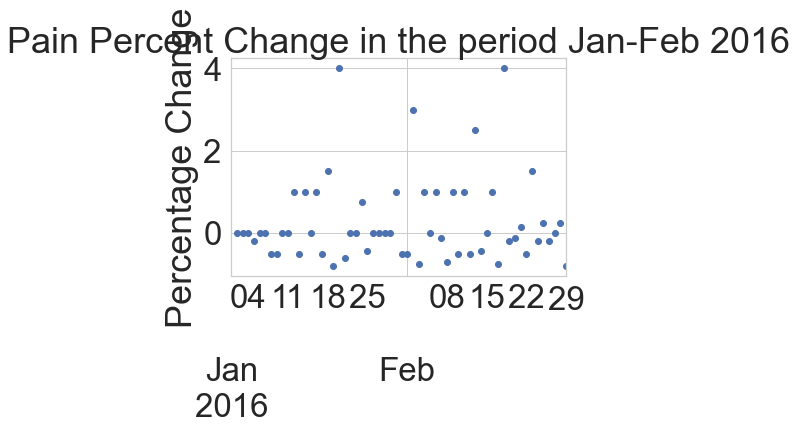

In [9]:
(part1
 .loc['01-2016':'02-2016']
 .plot(y='pain_pct_change',
       linestyle='',
       marker='o',
       title='Pain Percent Change in the period Jan-Feb 2016',
       ylabel='Percentage Change',
       legend=False
       
           ))

<AxesSubplot:title={'center':'Pain Change in the period Jan-Feb 2016'}, ylabel='Absolute Change'>

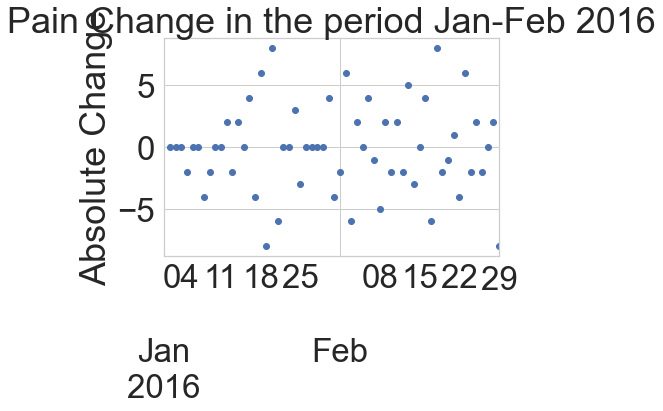

In [10]:
(part1
 .loc['01-2016':'02-2016']
 .plot(y='pain_change',
       linestyle='',
       marker='o',
       title='Pain Change in the period Jan-Feb 2016',
       ylabel='Absolute Change',
       legend=False
           ))

In [64]:
perc_of_non_zero(part1)['pain_pct_change']

0.3731506849315068

Has the problem changed for you? Did it get better? Should we take this into account.

In [12]:
(part1
 .query('pain_change>1')
 .shape
)

(307, 20)

We create the dataframes containing information on when pain peaks and pain drops occur

In [13]:
part1_painpeaks = part1.query('pain_change>1').copy()

<AxesSubplot:>

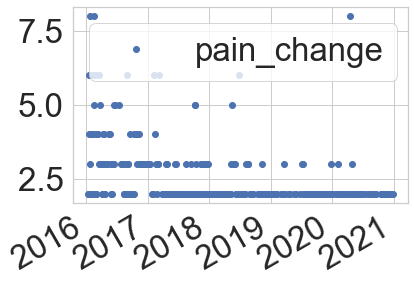

In [14]:
part1_painpeaks.plot(
    y='pain_change',
    linestyle='',
    marker='o'
)

In [15]:
part1_painpeaks.head()

,tracker_mean_distance,tracker_mean_denivelation,whatpulset_corrected,manictimedelta_corrected,timedrivingcar,...,scooterriding,kneepain,sick_tired,pain_pct_change,pain_change
2016-01-12,1.402768,18.936527,14531.0,594.0,0.0,...,0.0,4.0,1.0,1.0,2.0
2016-01-14,4.010163,18.936527,10713.0,478.0,13.0,...,0.0,4.0,1.0,1.0,2.0
2016-01-16,4.757137,18.936527,11646.0,435.0,15.0,...,0.0,8.0,1.0,1.0,4.0
2016-01-18,4.113617,18.936527,6270.0,281.0,60.0,...,0.0,10.0,1.0,1.5,6.0
2016-01-20,4.189892,18.936527,12682.0,528.0,13.0,...,0.0,10.0,1.0,4.0,8.0


The first pain peak is on January 12th 2016

In [16]:
part1_paindrops = part1.query('pain_change<0').copy()

In [27]:
painidxs = (part1
            .query('pain_change>1')
            .reset_index()
            .loc[:,['index']]
            .assign(date_range=lambda x:x['index']
                    .diff()
                    .dt.days
                   )
            .set_index('index')
            .query('date_range>2')
           )

In [30]:
painidxs.loc['2016-01-25':'2016-03-11']

,date_range
index,
2016-01-30,6.0
2016-02-02,3.0
2016-02-09,3.0
2016-02-16,3.0
2016-02-23,5.0
2016-02-28,3.0
2016-03-09,6.0


In [17]:
part1_paindrops.head()

,tracker_mean_distance,tracker_mean_denivelation,whatpulset_corrected,manictimedelta_corrected,timedrivingcar,...,scooterriding,kneepain,sick_tired,pain_pct_change,pain_change
2016-01-05,2.970361,18.936527,9377.0,537.0,9.0,...,0.0,8.0,1.0,-0.2,-2.0
2016-01-08,3.611251,18.936527,11465.0,546.0,12.0,...,0.0,4.0,1.0,-0.5,-4.0
2016-01-09,1.709623,18.936527,9425.0,481.0,12.0,...,0.0,2.0,1.0,-0.5,-2.0
2016-01-13,1.746446,18.936527,14354.0,573.0,10.0,...,0.0,2.0,1.0,-0.5,-2.0
2016-01-17,3.175516,18.936527,14836.0,547.0,12.0,...,0.0,4.0,1.0,-0.5,-4.0


There are multiple pain drops before the first peak that it probably makes little sense to consider

In [18]:
part1_paindrops = (part1_paindrops
                   .loc['2016-01-13':]
                  )

In [366]:
part1_peaksdrops = pd.concat([part1_painpeaks,part1_paindrops]).sort_index()

In [367]:
part1_peaksdrops.head()

,tracker_mean_distance,tracker_mean_denivelation,whatpulset_corrected,manictimedelta_corrected,timedrivingcar,...,scooterriding,kneepain,sick_tired,pain_pct_change,pain_change
2016-01-12,1.402768,18.936527,14531.0,594.0,0.0,...,0.0,4.0,1.0,1.0,2.0
2016-01-13,1.746446,18.936527,14354.0,573.0,10.0,...,0.0,2.0,1.0,-0.5,-2.0
2016-01-14,4.010163,18.936527,10713.0,478.0,13.0,...,0.0,4.0,1.0,1.0,2.0
2016-01-16,4.757137,18.936527,11646.0,435.0,15.0,...,0.0,8.0,1.0,1.0,4.0
2016-01-17,3.175516,18.936527,14836.0,547.0,12.0,...,0.0,4.0,1.0,-0.5,-4.0


We create information on the time distribution of these events 

In [368]:
daterangepeaks = (part1_painpeaks          
                  .copy()
                  .reset_index()
                  .loc[:,['index']]
                  .assign(date_range=lambda x:x['index']
                          .diff()
                          .dt.days
                         )
                  .set_index('index')
                 )

daterangedrops = (part1_paindrops          
                  .copy()
                  .reset_index()
                  .loc[:,['index']]
                  .assign(date_range=lambda x:x['index']
                          .diff()
                          .dt.days
                         )
                  .set_index('index')
                 )

In [369]:
daterangepeaks.head(10)

,date_range
index,
2016-01-12,NaN
2016-01-14,2.0
2016-01-16,2.0
2016-01-18,2.0
2016-01-20,2.0
2016-01-24,4.0
2016-01-30,6.0
2016-02-02,3.0
2016-02-04,2.0


In [370]:
daterangedrops.head(10)

,date_range
index,
2016-01-13,NaN
2016-01-17,4.0
2016-01-19,2.0
2016-01-21,2.0
2016-01-25,4.0
2016-01-31,6.0
2016-02-01,1.0
2016-02-03,2.0
2016-02-07,4.0


<AxesSubplot:xlabel='date_range', ylabel='Count'>

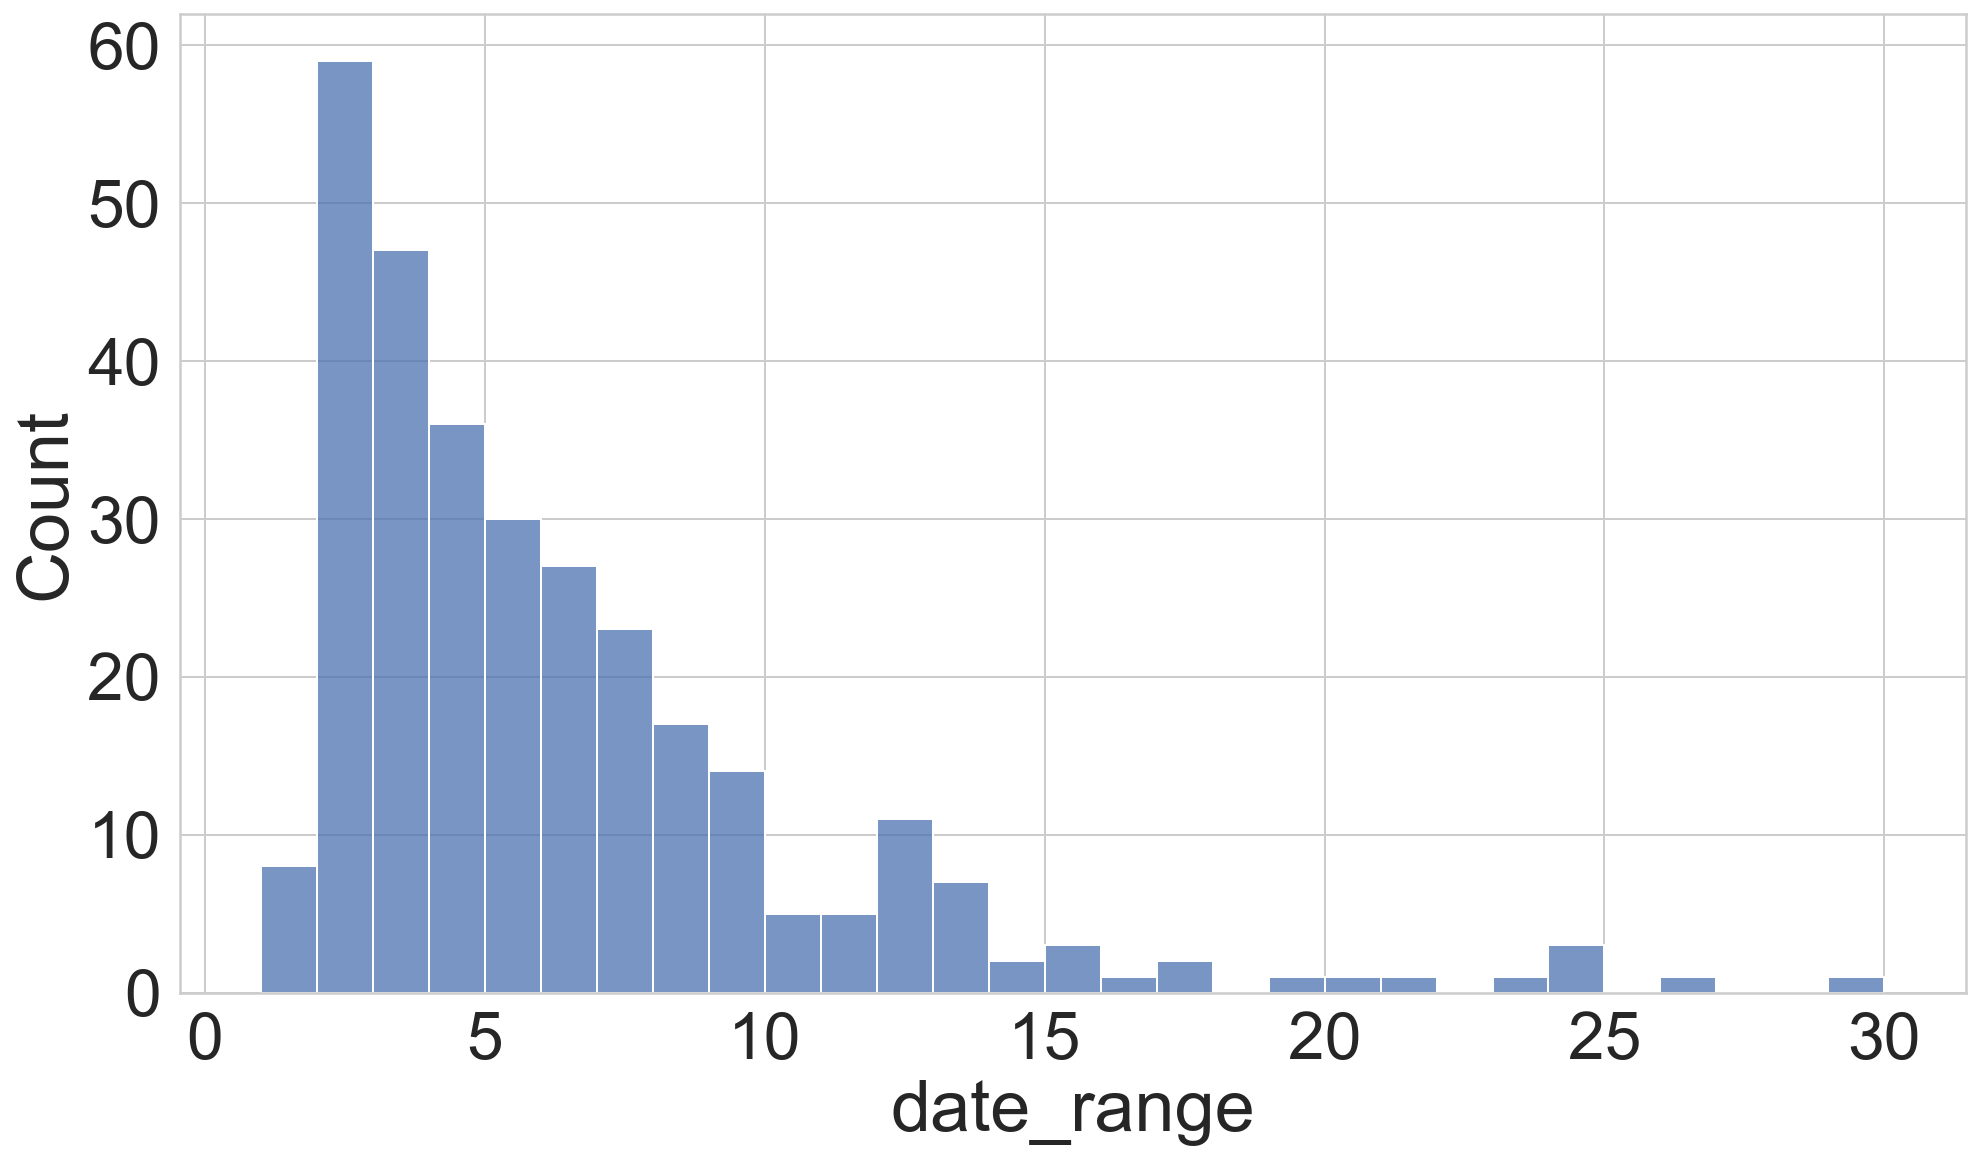

In [371]:
sns.histplot(data=daterange,
             x='date_range',
             binwidth=1
            )

The distribution is heavily peaked on very short time delta. There appear to be very frequent "reflaring" of the pain. We could start by dropping those with a single day between them (it likely just means that the pain aggravated in two consecutive days). We could then imagine of using the day before (and the day of?) a pain occurrence as our observation time and other 2-day periods with no pain peak as the "controls".

We want to check if the time between pain peaks has changed over time as this might in principle affect the analysis (in the sense that we might need to do a year-by-year analysis)

In [372]:
(daterangepeaks
 .groupby(daterange.index.year)
 .agg(mean_yearly_datarange=('date_range',np.mean))
)

,mean_yearly_datarange
index,
2016,4.358025
2017,5.289855
2018,5.967213
2019,7.408163
2020,7.891304


<AxesSubplot:xlabel='date_range', ylabel='Count'>

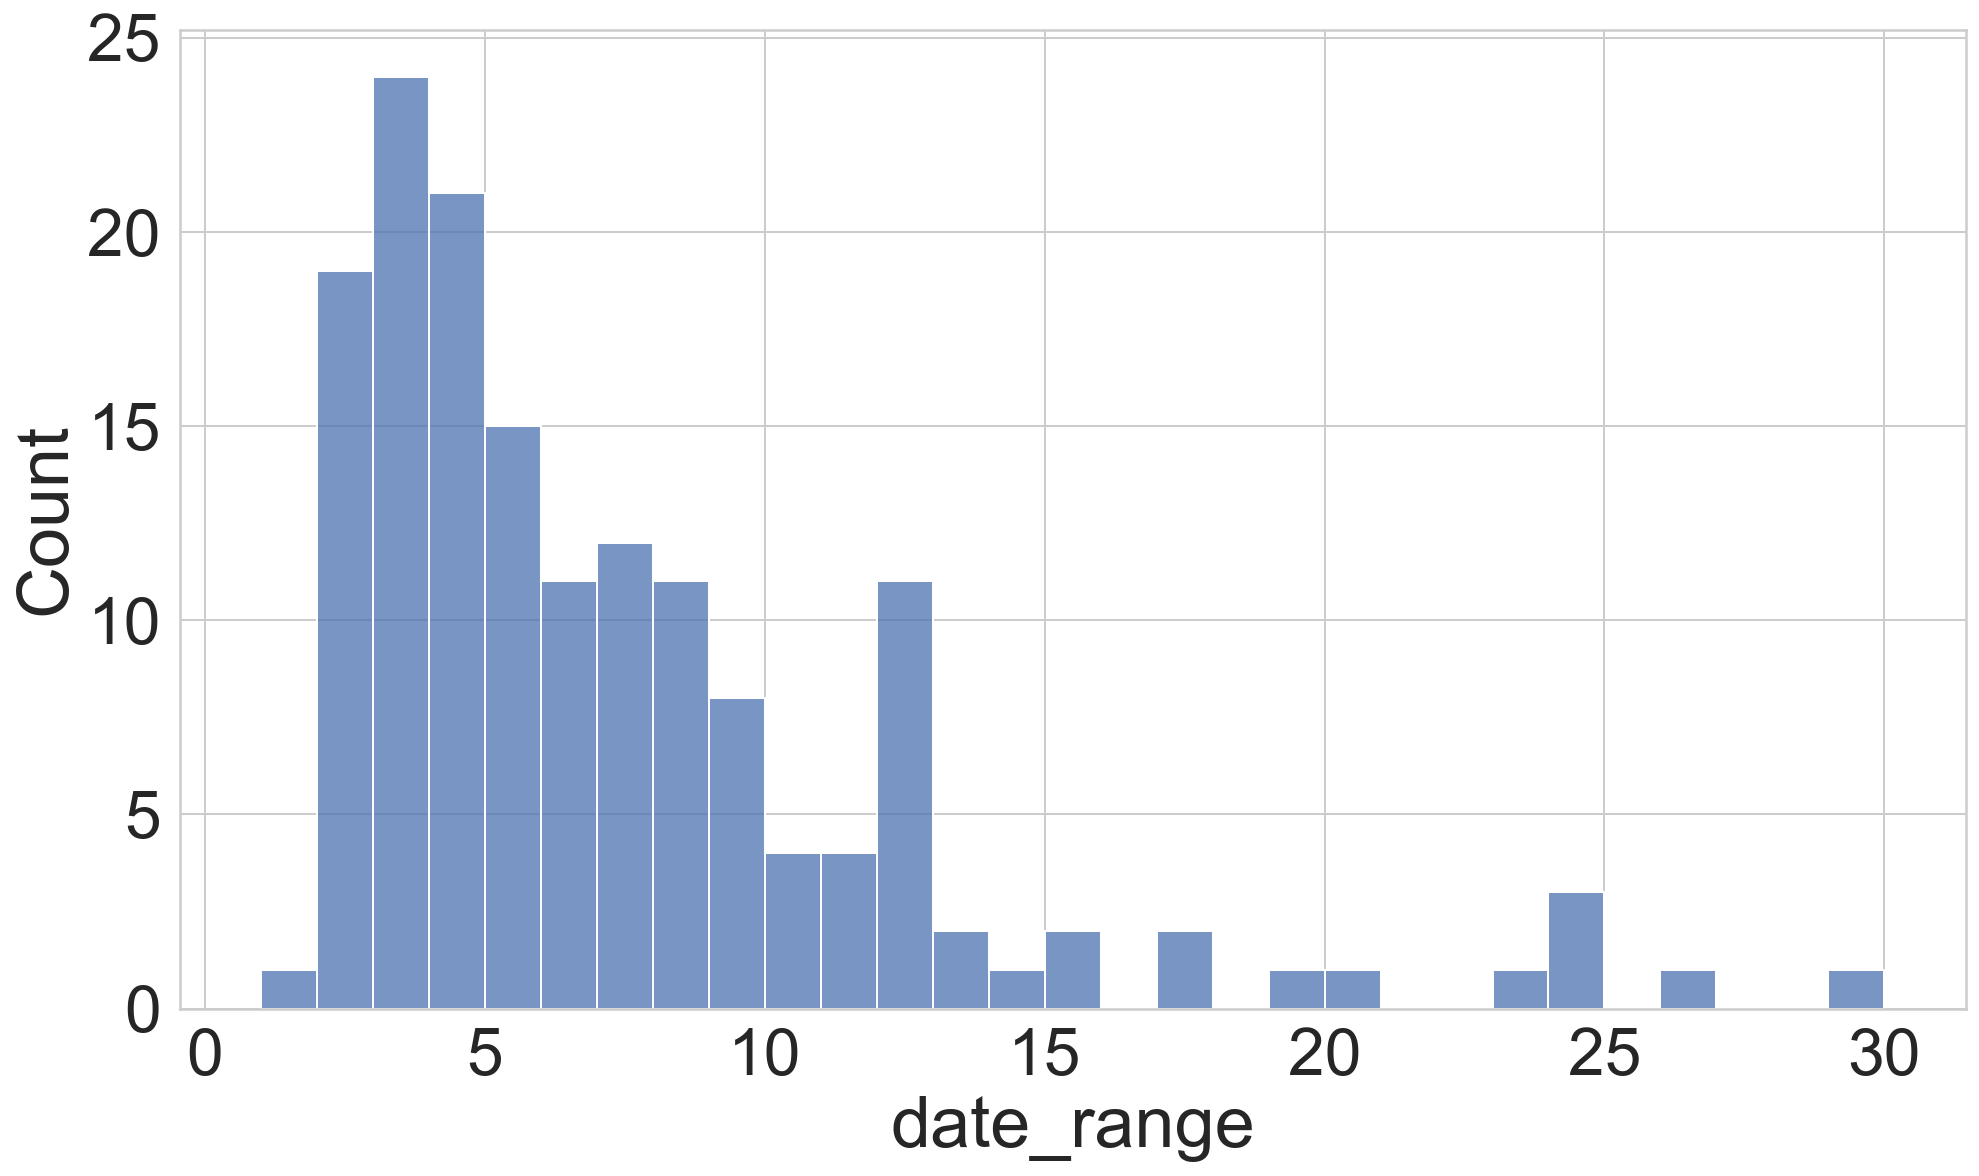

In [373]:
sns.histplot(data=daterangepeaks.loc['2018':'2021'],
             x='date_range',
             binwidth=1
            )

The average is clearly different but maybe we can start with considering the whole time range

In [374]:
painindex = daterangepeaks.query('date_range>2').index
dropindex = daterangedrops.index

We create index dataset identifying pain time ranges and "between-pain" time ranges

In [822]:
paindates = painindex.union(painindex-pd.DateOffset(days=1)).unique()

# paindates = pd.DatetimeIndex(
#     [idx for idx in painrange if idx-pd.TimeDelta(days=2) not in painrange]
# )

postpainrange = (((dropindex+pd.DateOffset(days=2))
                  .union(dropindex+pd.DateOffset(days=3)))
                 .unique()
                )
       
postpain = pd.DatetimeIndex(
    [idx for idx in postpainrange 
     if idx not in 
     daterangepeaks.index.union(daterangepeaks.index-pd.DateOffset(days=1))]
)
# nopaindates = pd.DatetimeIndex(
#     [idx for idx in postpain if
#      ((idx-pd.Timedelta(days=1) in postpain) or (idx+pd.Timedelta(days=1) in postpain)) and
#       ((idx-pd.Timedelta(days=2) not in postpain) and (idx+pd.Timedelta(days=2) not in postpain))]
# )

# nopaindates = pd.DatetimeIndex(
#     [idx for idx in postpain if
#      ((idx+pd.Timedelta(days=1) in postpain) and (idx+pd.Timedelta(days=2) not in postpain)) !=
#      ((idx-pd.Timedelta(days=1) in postpain) and (idx-pd.Timedelta(days=2) not in postpain))]
# )

temp_dates = []

# This approach is for when we only have isolated pair of days
for i,idx in enumerate(postpain):
    if idx+pd.Timedelta(days=1) in postpain:
        if idx+pd.Timedelta(days=2) not in postpain:
            temp_dates.append(idx)
            temp_dates.append(postpain[i+1])
        else:
            pass
    else:
        pass
    

# Trying to consider also consecutive pairs of days
# for i,idx in enumerate(postpain):
#     if idx+pd.Timedelta(days=1) in postpain:
#         if idx+pd.Timedelta(days=2) not in postpain:
#             temp_dates.append(idx)
#             temp_dates.append(postpain[i+1])
#         elif idx+pd.Timedelta(days=3) in postpain:
#             temp_dates.append(idx)
#             temp_dates.append(postpain[i+1])
#             temp_dates.append(postpain[i+2])
#             temp_dates.append(postpain[i+3])
#             i += 4
#         else:
#             pass
#     else:
#         pass

nopaindates = pd.DatetimeIndex(temp_dates)

In [613]:
paindates.shape

(478,)

In [823]:
nopaindates.shape

(262,)

In [816]:
[idx for idx in paindates if idx in nopaindates]

[]

In [817]:
pain = (part1
        .pipe(start_pipeline)
        .iloc[part1.index.isin(paindates)]
       )

nopain = (part1
          .pipe(start_pipeline)
          .iloc[part1.index.isin(nopaindates)]
         )

start_pipeline returns a (1825, 20) dataframe
start_pipeline returns a (1825, 20) dataframe


In [818]:
cols = [col for sublist in 
        np.array([['%s_%d' %(name,idx) for idx in range(2)] for name in pain.columns])
        for col in sublist]

In [834]:
twodaypain = (pain
              .reset_index()
              .assign(event_num=lambda x:(x['index'].diff()>pd.Timedelta(days=1)).cumsum(),
                      counter = lambda x:1,
                      day_num = lambda x:x.groupby('event_num').agg({'counter':np.cumsum})
                     )
              .drop(['counter'],axis=1)
              .pivot(index='event_num',columns='day_num',values=pain.columns)
              .assign(pain=lambda x:1)
             )

# twodaynopain = (nopain
#                 .reset_index()
#                 .assign(event_num=lambda x:(x['index'].diff()>pd.Timedelta(days=1)).cumsum(),
#                         counter = lambda x:1,
#                         day_num = lambda x:x.groupby('event_num').agg({'counter':np.cumsum})
#                        )
#                 .drop(['counter'],axis=1)
#                 .pivot(index='event_num',columns='day_num',values=nopain.columns)
#                 .assign(pain=lambda x:0)
#                )

# We try to pair rows that might also be consecutive
# We can still add repetition of the rows
twodaynopain = (nopain
                .reset_index()
                .assign(event_num = lambda x:(x.index.values%2==0).cumsum(),
                        counter = lambda x:1,
                        day_num = lambda x:x.groupby('event_num').agg({'counter':np.cumsum})
                       )
                .drop(['counter'],axis=1)
                .pivot(index='event_num',columns='day_num',values=nopain.columns)
                .assign(pain=lambda x:0)
               )

part1final = (pd.concat([twodaypain.copy(),twodaynopain.copy()])
              .reset_index()
             )

In [838]:
part1final.isnull().sum().sum()

0

In [836]:
part1final.columns = ['event_num'] + cols + ['pain']
cols_to_drop = ['event_num',
                'kneepain_0',
                'pain_pct_change_0',
                'pain_change_0',
                'tracker_mean_denivelation_0',
                'tracker_mean_denivelation_1'
               ]
part1final = part1final.drop(cols_to_drop,axis=1)

In [837]:
part1final.head(30)

,tracker_mean_distance_0,tracker_mean_distance_1,whatpulset_corrected_0,whatpulset_corrected_1,manictimedelta_corrected_0,...,sick_tired_0,sick_tired_1,pain_pct_change_1,pain_change_1,pain
0,4.832535,5.211283,0.000000,5546.0,0.000000,...,1.0,1.0,0.750000,3.0,1
1,4.401184,3.887420,7438.000000,6306.0,373.000000,...,1.0,1.0,1.000000,4.0,1
2,2.941429,3.995258,7812.000000,4676.0,364.000000,...,1.0,1.0,3.000000,6.0,1
3,2.511831,3.406096,13659.000000,11748.0,498.000000,...,1.0,1.0,1.000000,2.0,1
4,4.011039,3.324560,14426.000000,9805.0,484.000000,...,1.0,1.0,1.000000,4.0,1
...,...,...,...,...,...,...,...,...,...,...,...
25,1.456248,3.498152,11654.000000,12272.0,520.000000,...,1.0,1.0,0.750000,3.0,1
26,1.196736,1.294053,14683.000000,13634.0,522.000000,...,1.0,1.0,0.750000,3.0,1
27,5.463781,7.811664,347.775659,0.0,3.594271,...,1.0,1.0,0.250000,2.0,1
28,7.425902,7.123431,1504.000000,1461.0,40.000000,...,1.0,1.0,0.250000,2.0,1


There appear to be a lot of repeated values for some of the columns? Why is the tracker_mean_deniveletion exactly the same for several days?

In [652]:
part1final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 370 entries, 0 to 369
Data columns (total 36 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   tracker_mean_distance_0        370 non-null    float64
 1   tracker_mean_distance_1        370 non-null    float64
 2   whatpulset_corrected_0         370 non-null    float64
 3   whatpulset_corrected_1         370 non-null    float64
 4   manictimedelta_corrected_0     370 non-null    float64
 5   manictimedelta_corrected_1     370 non-null    float64
 6   timedrivingcar_0               370 non-null    float64
 7   timedrivingcar_1               370 non-null    float64
 8   climbingdenivelation_0         370 non-null    float64
 9   climbingdenivelation_1         370 non-null    float64
 10  climbingmaxeffortintensity_0   370 non-null    float64
 11  climbingmaxeffortintensity_1   370 non-null    float64
 12  climbingmeaneffortintensity_0  370 non-null    flo

In [651]:
perc_unique_values(part1final)

tracker_mean_distance_0                 0.8027027027027027                      
tracker_mean_distance_1                 0.8567567567567568                      
whatpulset_corrected_0                  0.9675675675675676                      
whatpulset_corrected_1                  0.981081081081081                       
manictimedelta_corrected_0              0.7                                     
manictimedelta_corrected_1              0.7621621621621621                      
timedrivingcar_0                        0.11621621621621622                     
timedrivingcar_1                        0.14594594594594595                     
climbingdenivelation_0                  0.06486486486486487                     
climbingdenivelation_1                  0.05945945945945946                     
climbingmaxeffortintensity_0            0.05405405405405406                     
climbingmaxeffortintensity_1            0.05675675675675676                     
climbingmeaneffortintensity_

<AxesSubplot:>

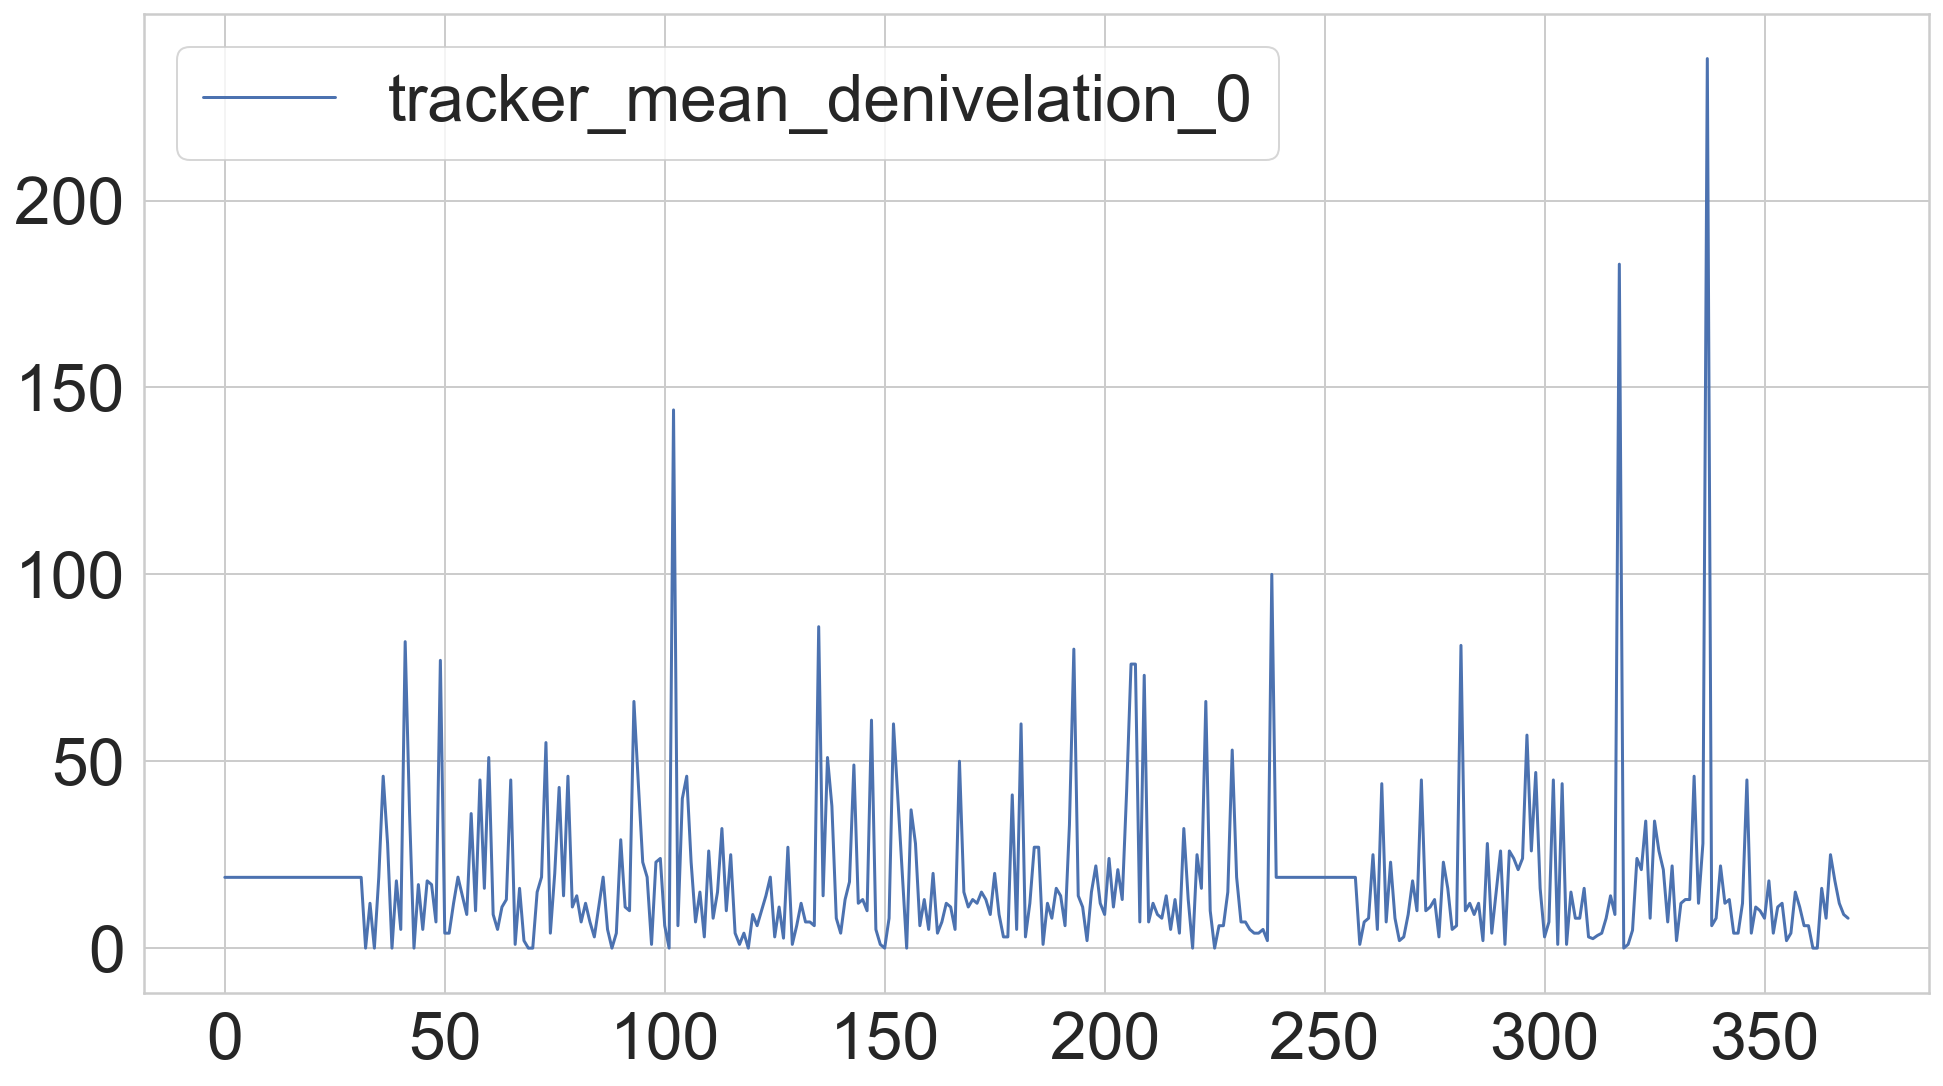

In [503]:
part1final.plot(y='tracker_mean_denivelation_0')

What do we do with the fact that there are these periods of constant value?

<ipython-input-648-1f1fd385c4e5>:2: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  part1final.hist(ax=ax)


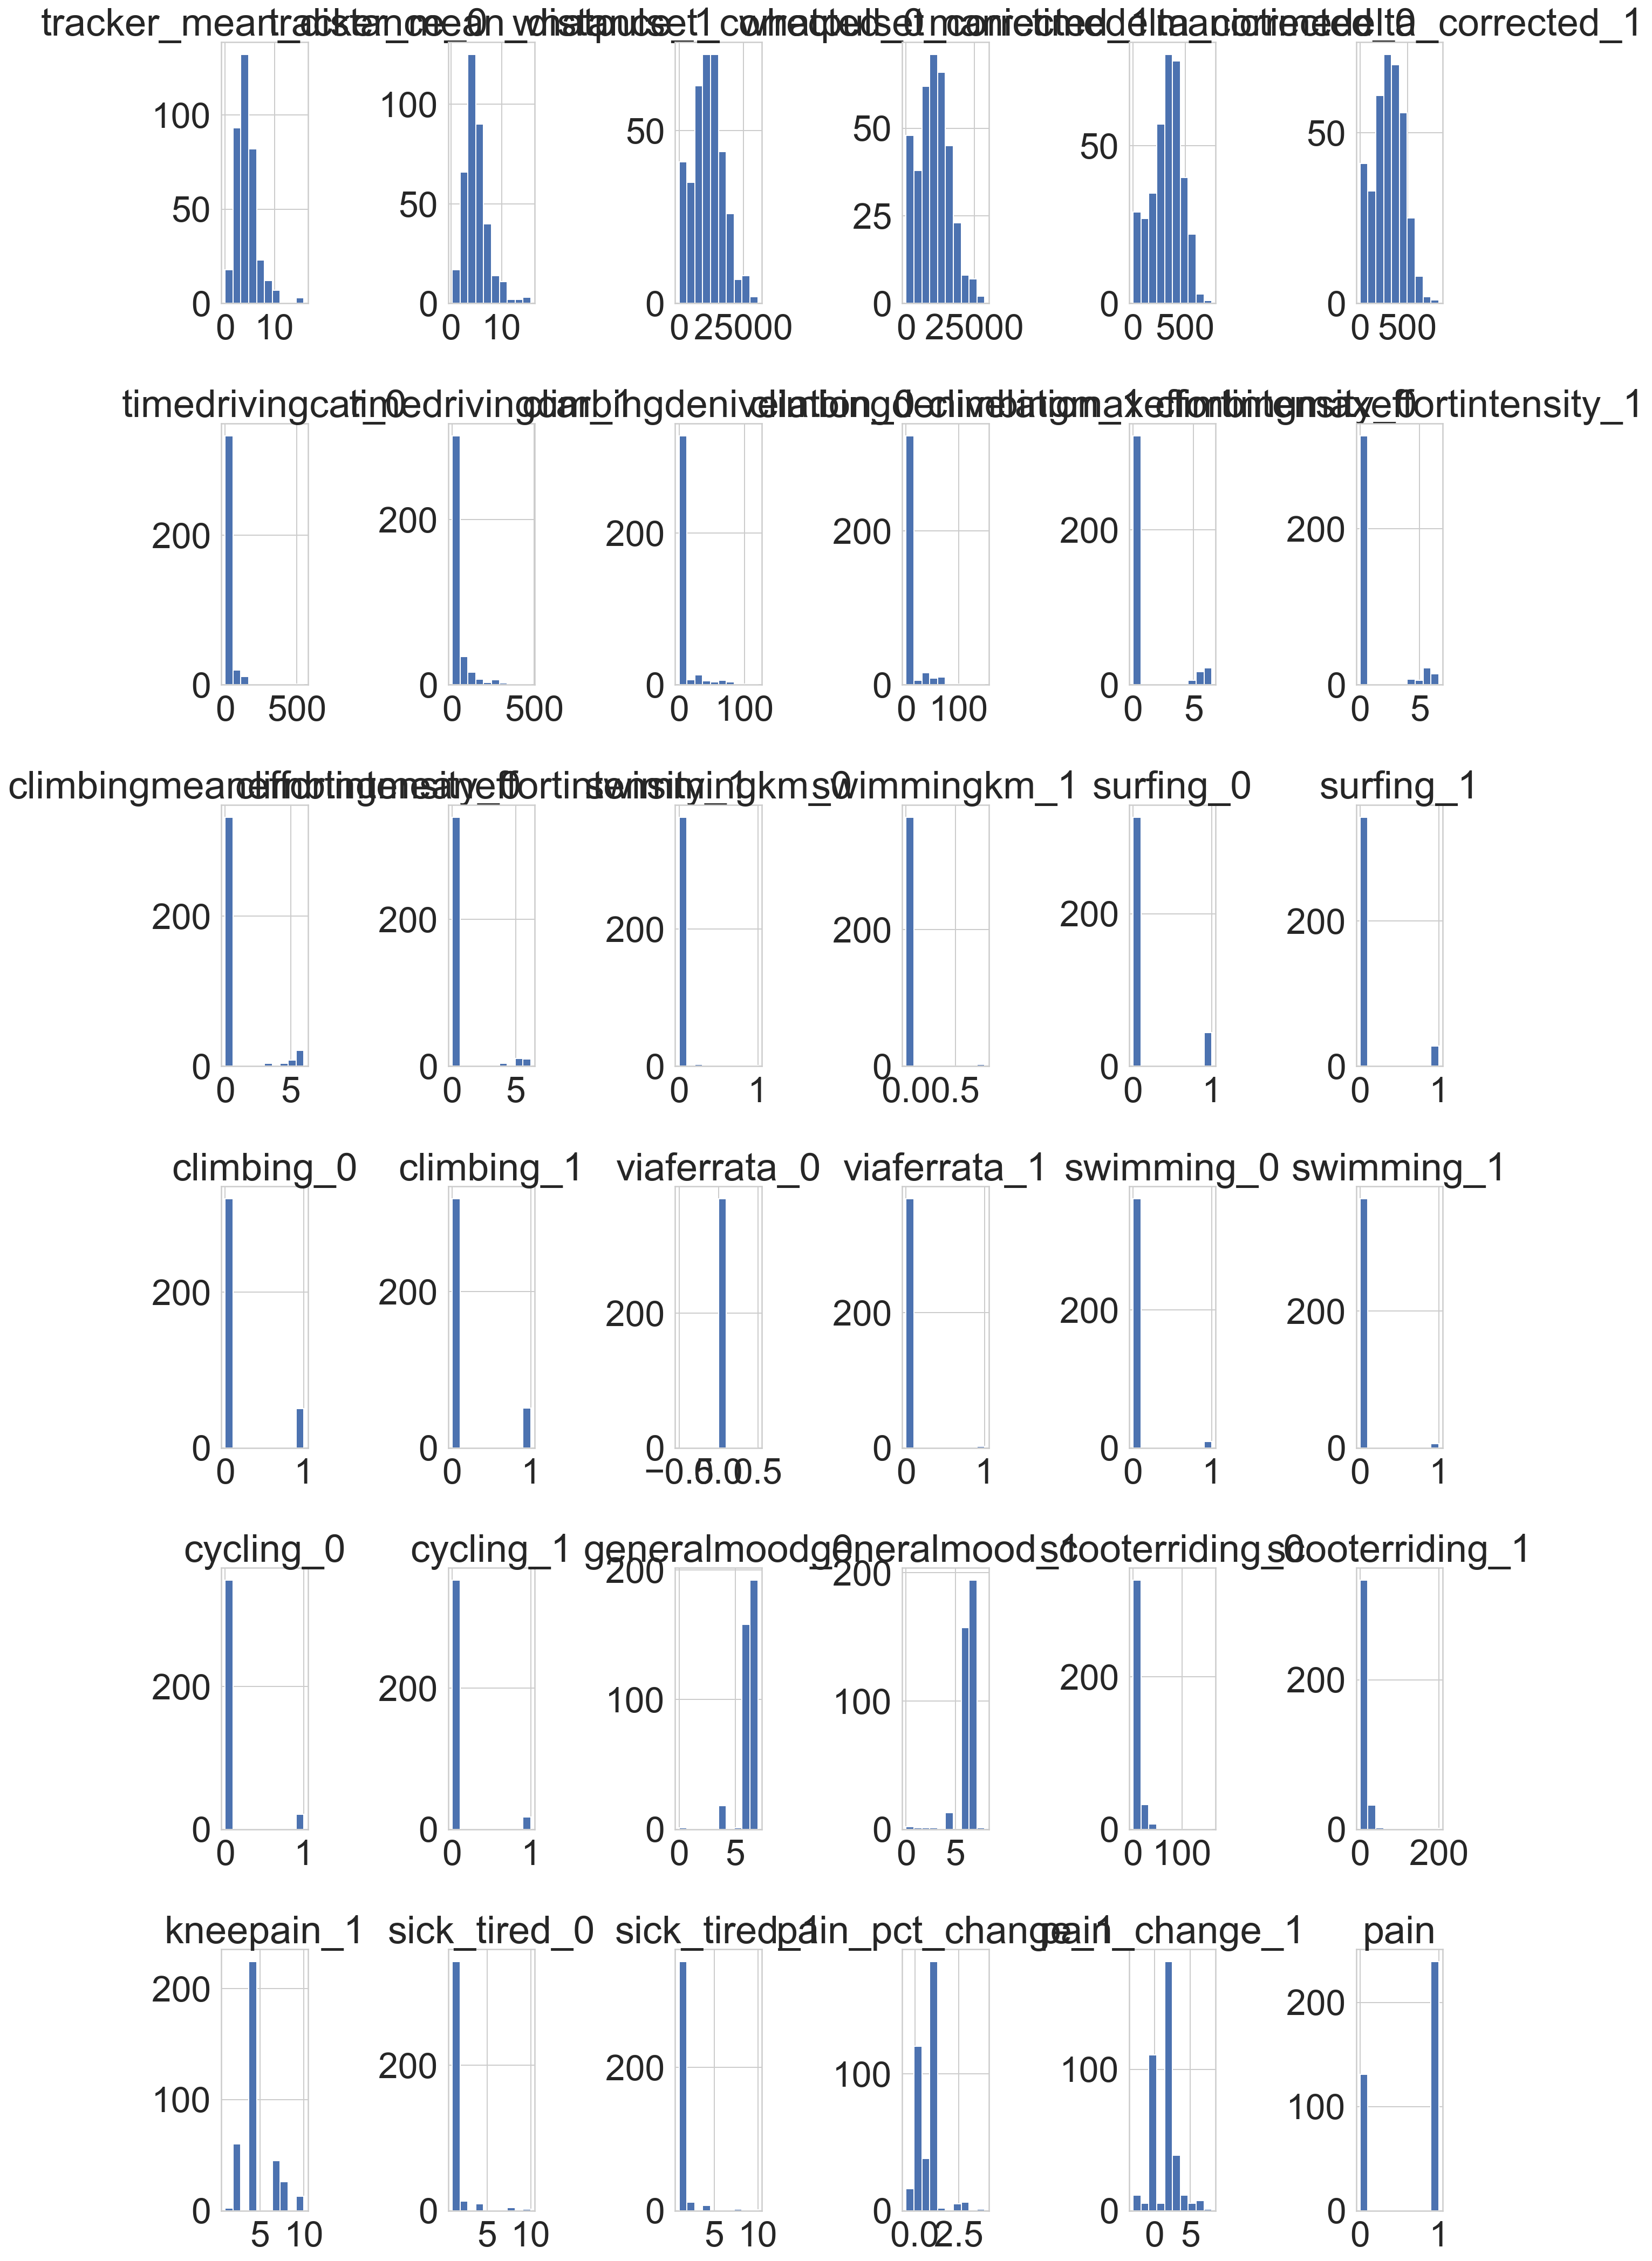

In [648]:
fig,ax = plt.subplots(1,figsize=(18,30))
part1final.hist(ax=ax)
plt.tight_layout()

In [511]:
part1final.columns

Index(['tracker_mean_distance_0', 'tracker_mean_distance_1',
       'tracker_mean_denivelation_0', 'tracker_mean_denivelation_1',
       'whatpulset_corrected_0', 'whatpulset_corrected_1',
       'manictimedelta_corrected_0', 'manictimedelta_corrected_1',
       'timedrivingcar_0', 'timedrivingcar_1', 'climbingdenivelation_0',
       'climbingdenivelation_1', 'climbingmaxeffortintensity_0',
       'climbingmaxeffortintensity_1', 'climbingmeaneffortintensity_0',
       'climbingmeaneffortintensity_1', 'swimmingkm_0', 'swimmingkm_1',
       'surfing_0', 'surfing_1', 'climbing_0', 'climbing_1', 'viaferrata_0',
       'viaferrata_1', 'swimming_0', 'swimming_1', 'cycling_0', 'cycling_1',
       'generalmood_0', 'generalmood_1', 'scooterriding_0', 'scooterriding_1',
       'kneepain_1', 'sick_tired_0', 'sick_tired_1', 'pain_pct_change_1',
       'pain_change_1', 'pain'],
      dtype='object')

<AxesSubplot:>

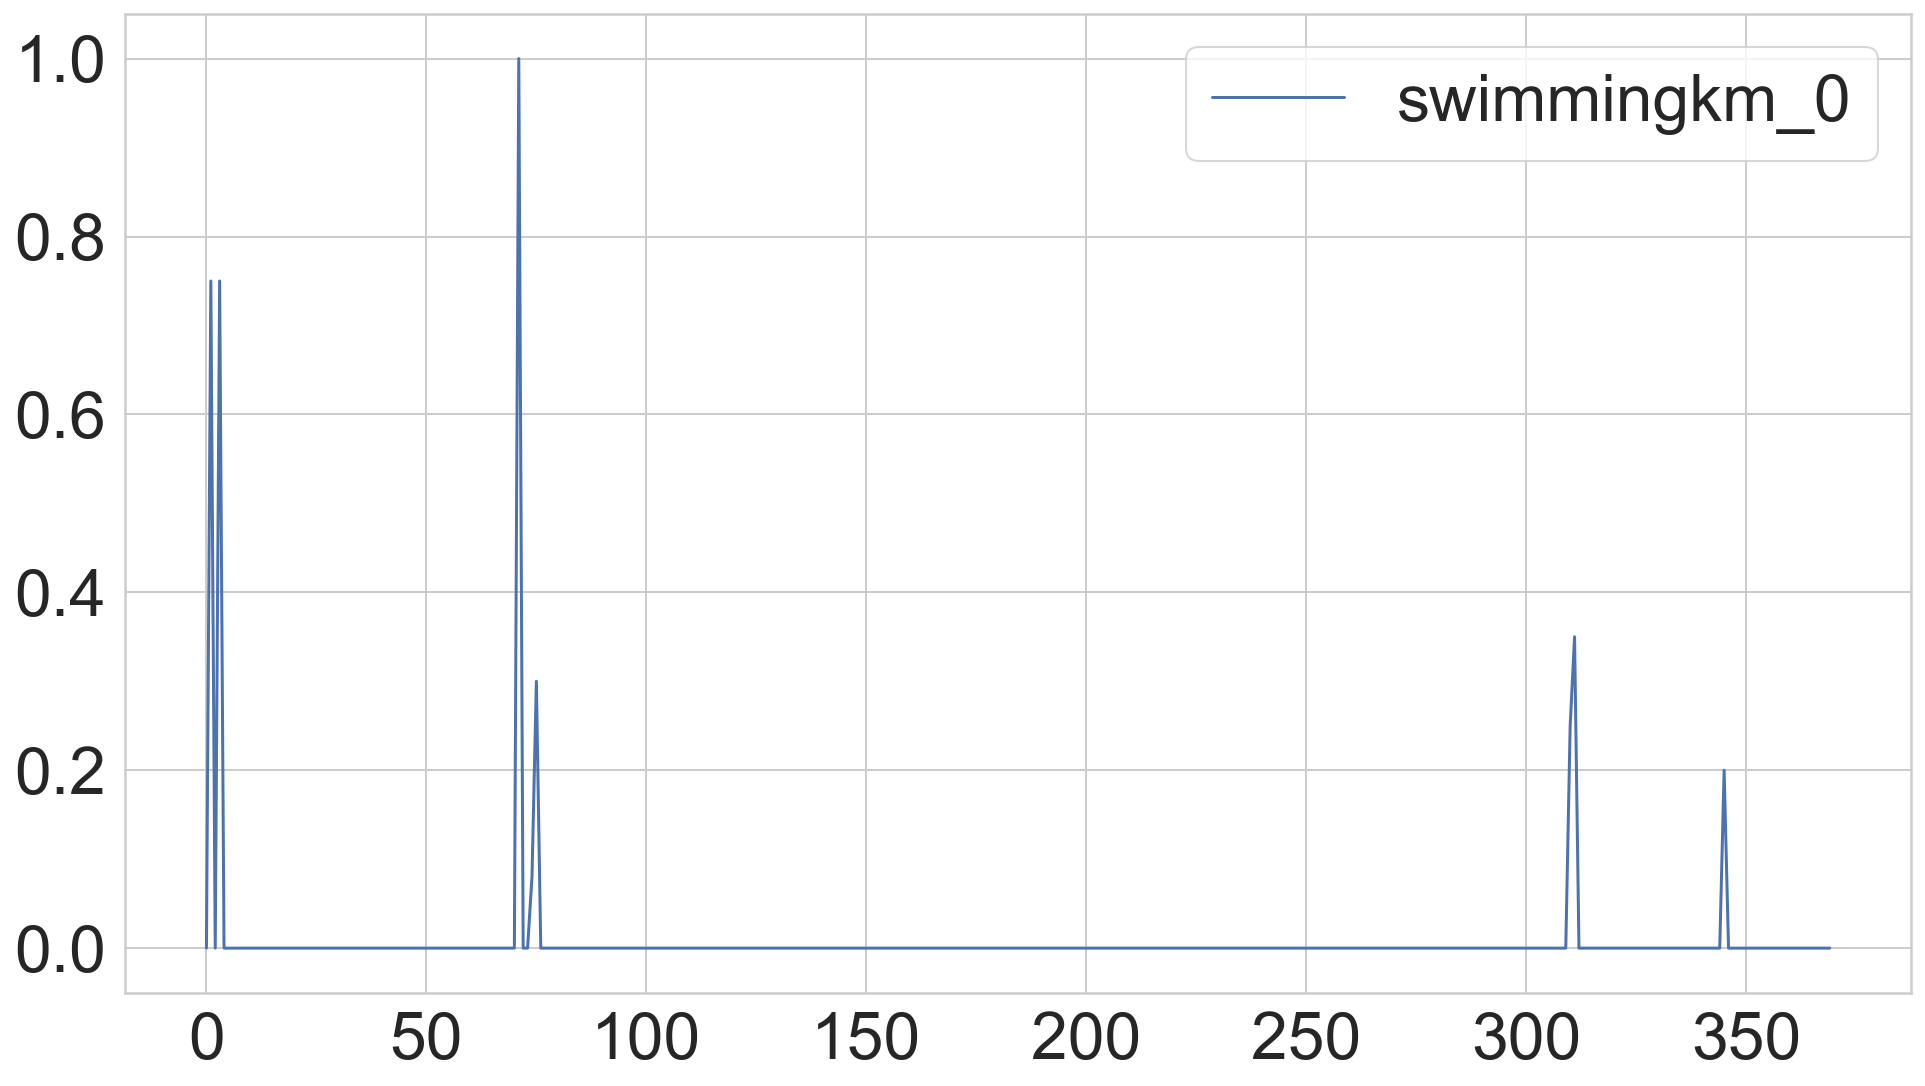

In [518]:
part1final.plot(y='swimmingkm_0')

In [650]:
part1final['viaferrata_1'].unique()

array([0., 1.])

In [672]:
part1final.corr()['pain'].sort_values(ascending=False)[4:]

tracker_mean_distance_1       0.113970
surfing_0                     0.097396
timedrivingcar_1              0.095906
viaferrata_1                  0.054579
scooterriding_1               0.052486
                                ...   
whatpulset_corrected_0       -0.075768
whatpulset_corrected_1       -0.103401
manictimedelta_corrected_0   -0.118831
manictimedelta_corrected_1   -0.129083
viaferrata_0                       NaN
Name: pain, Length: 32, dtype: float64

In [681]:
perc_of_non_zero(part1final)

tracker_mean_distance_0                 99.19                                   
tracker_mean_distance_1                 100.0                                   
whatpulset_corrected_0                  97.84                                   
whatpulset_corrected_1                  98.92                                   
manictimedelta_corrected_0              97.84                                   
manictimedelta_corrected_1              98.92                                   
timedrivingcar_0                        72.16                                   
timedrivingcar_1                        72.7                                    
climbingdenivelation_0                  12.97                                   
climbingdenivelation_1                  13.24                                   
climbingmaxeffortintensity_0            13.24                                   
climbingmaxeffortintensity_1            13.78                                   
climbingmeaneffortintensity_

In [682]:
part1final.columns

Index(['tracker_mean_distance_0', 'tracker_mean_distance_1',
       'whatpulset_corrected_0', 'whatpulset_corrected_1',
       'manictimedelta_corrected_0', 'manictimedelta_corrected_1',
       'timedrivingcar_0', 'timedrivingcar_1', 'climbingdenivelation_0',
       'climbingdenivelation_1', 'climbingmaxeffortintensity_0',
       'climbingmaxeffortintensity_1', 'climbingmeaneffortintensity_0',
       'climbingmeaneffortintensity_1', 'swimmingkm_0', 'swimmingkm_1',
       'surfing_0', 'surfing_1', 'climbing_0', 'climbing_1', 'viaferrata_0',
       'viaferrata_1', 'swimming_0', 'swimming_1', 'cycling_0', 'cycling_1',
       'generalmood_0', 'generalmood_1', 'scooterriding_0', 'scooterriding_1',
       'kneepain_1', 'sick_tired_0', 'sick_tired_1', 'pain_pct_change_1',
       'pain_change_1', 'pain'],
      dtype='object')

We drop the swimming and via ferrata for now, which provide very little information

In [683]:
part1final = (part1final
              .drop(['swimmingkm_0', 'swimmingkm_1',
                     'viaferrata_0', 'viaferrata_1', 
                     'swimming_0', 'swimming_1'
                    ],axis=1)
             )

<AxesSubplot:>

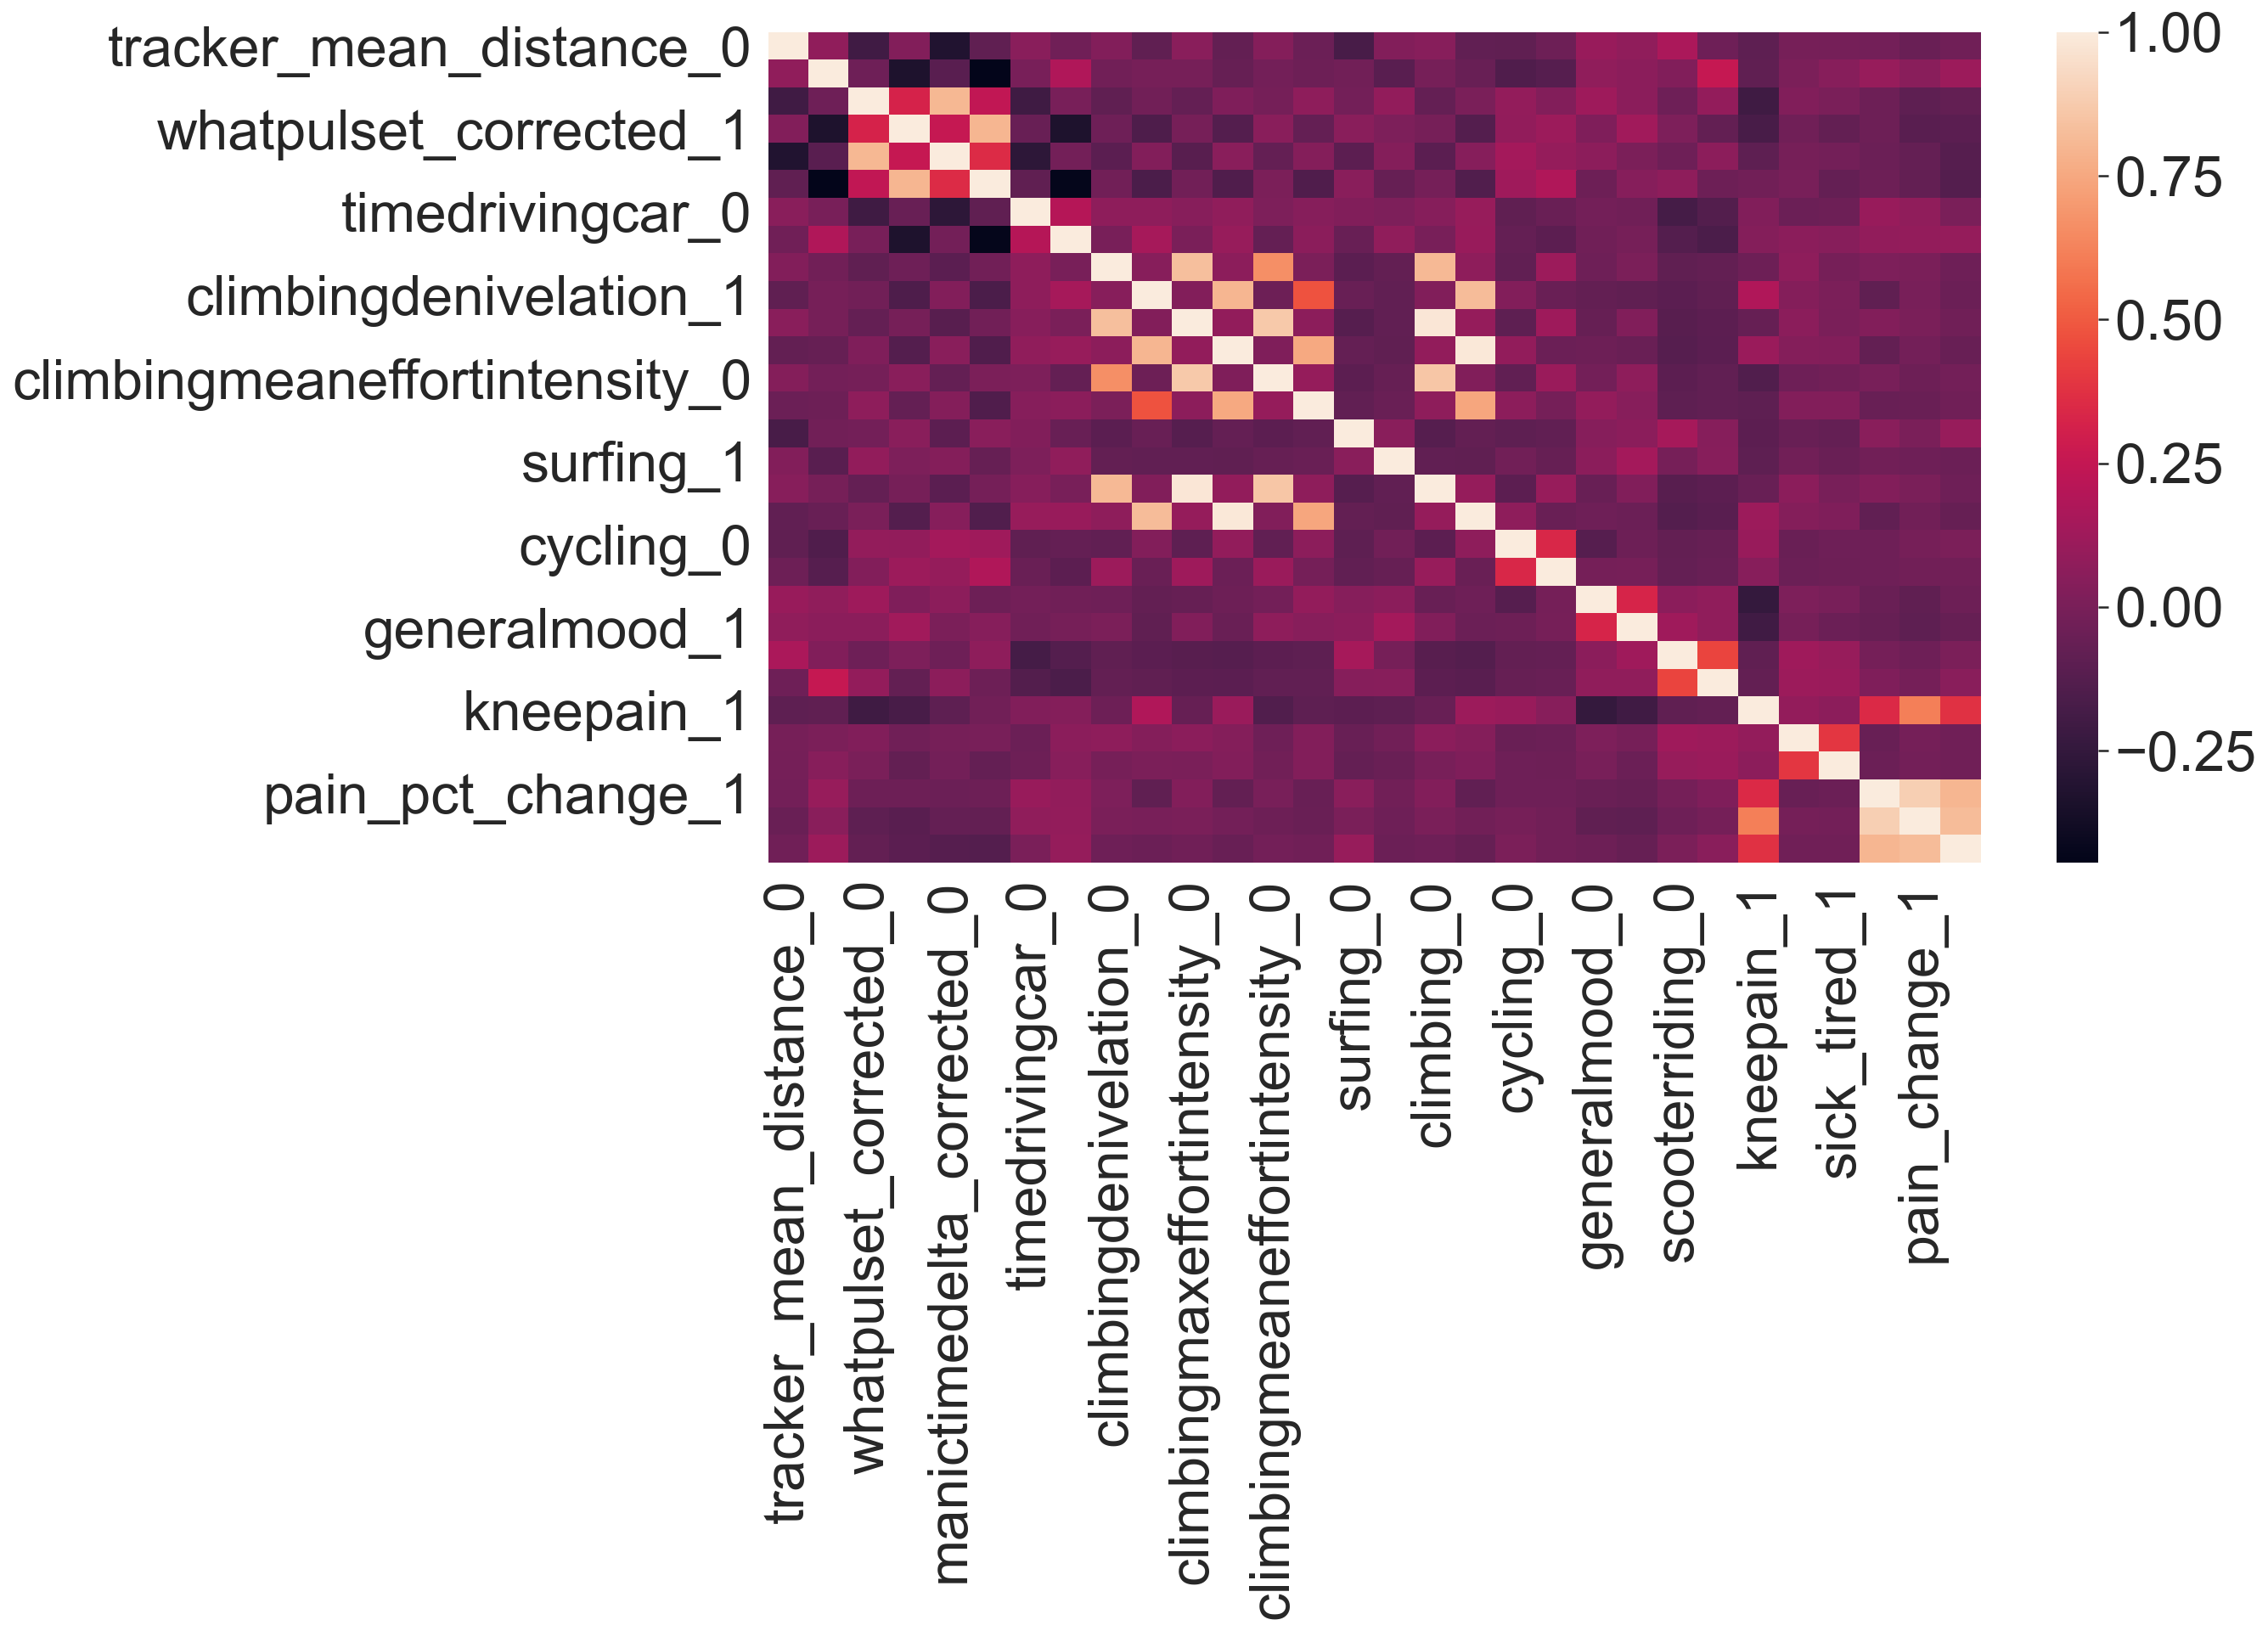

In [684]:
sns.heatmap(part1final.corr())

***
# Some modeling

## Classification attempt

Here we drop the explicit values for the pain or pain change and only keep the pain label

In [685]:
part1final.columns

Index(['tracker_mean_distance_0', 'tracker_mean_distance_1',
       'whatpulset_corrected_0', 'whatpulset_corrected_1',
       'manictimedelta_corrected_0', 'manictimedelta_corrected_1',
       'timedrivingcar_0', 'timedrivingcar_1', 'climbingdenivelation_0',
       'climbingdenivelation_1', 'climbingmaxeffortintensity_0',
       'climbingmaxeffortintensity_1', 'climbingmeaneffortintensity_0',
       'climbingmeaneffortintensity_1', 'surfing_0', 'surfing_1', 'climbing_0',
       'climbing_1', 'cycling_0', 'cycling_1', 'generalmood_0',
       'generalmood_1', 'scooterriding_0', 'scooterriding_1', 'kneepain_1',
       'sick_tired_0', 'sick_tired_1', 'pain_pct_change_1', 'pain_change_1',
       'pain'],
      dtype='object')

In [690]:
X = part1final.drop(['kneepain_1',
                     'pain_pct_change_1',
                     'pain_change_1',
                     'pain'
                    ],axis=1)
y = part1final['pain']

In [695]:
from sklearn.model_selection import train_test_split, GridSearchCV

In [692]:
X_train_val,X_test,y_train_val,y_test, = train_test_split(X,y,test_size=0.2,random_state=42)
X_train,X_val,y_train,y_val = train_test_split(X_train_val,y_train_val,test_size=0.2,random_state=42)

In [694]:
from sklearn.ensemble import RandomForestClassifier

In [696]:
rf_clf = RandomForestClassifier()

In [702]:
param_grid = {
    'n_estimators':np.arange(150,250,10),
    'max_depth':np.arange(2,30,1)
}

In [703]:
search = GridSearchCV(rf_clf,param_grid=param_grid,cv=5,n_jobs=-1,scoring='accuracy',return_train_score=True)

In [704]:
search.fit(X_train,y_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'max_depth': array([ 2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18,
       19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29]),
                         'n_estimators': array([150, 160, 170, 180, 190, 200, 210, 220, 230, 240])},
             return_train_score=True, scoring='accuracy')

In [705]:
search.best_estimator_

RandomForestClassifier(max_depth=9, n_estimators=180)

In [706]:
search.best_score_

0.6607269503546099

In [710]:
row_format="{:<40}" * 2
for col, score in zip(X_train.columns,search.best_estimator_.feature_importances_):
    print(row_format.format(col,score))

tracker_mean_distance_0                 0.10396332317215289                     
tracker_mean_distance_1                 0.10710088877851394                     
whatpulset_corrected_0                  0.09847004978399462                     
whatpulset_corrected_1                  0.11930371866730169                     
manictimedelta_corrected_0              0.10122615090663332                     
manictimedelta_corrected_1              0.09063696334865401                     
timedrivingcar_0                        0.06992836480878666                     
timedrivingcar_1                        0.07973312652571463                     
climbingdenivelation_0                  0.015743557364243543                    
climbingdenivelation_1                  0.01790470304366695                     
climbingmaxeffortintensity_0            0.014489830740828253                    
climbingmaxeffortintensity_1            0.014764257258022653                    
climbingmeaneffortintensity_

<AxesSubplot:>

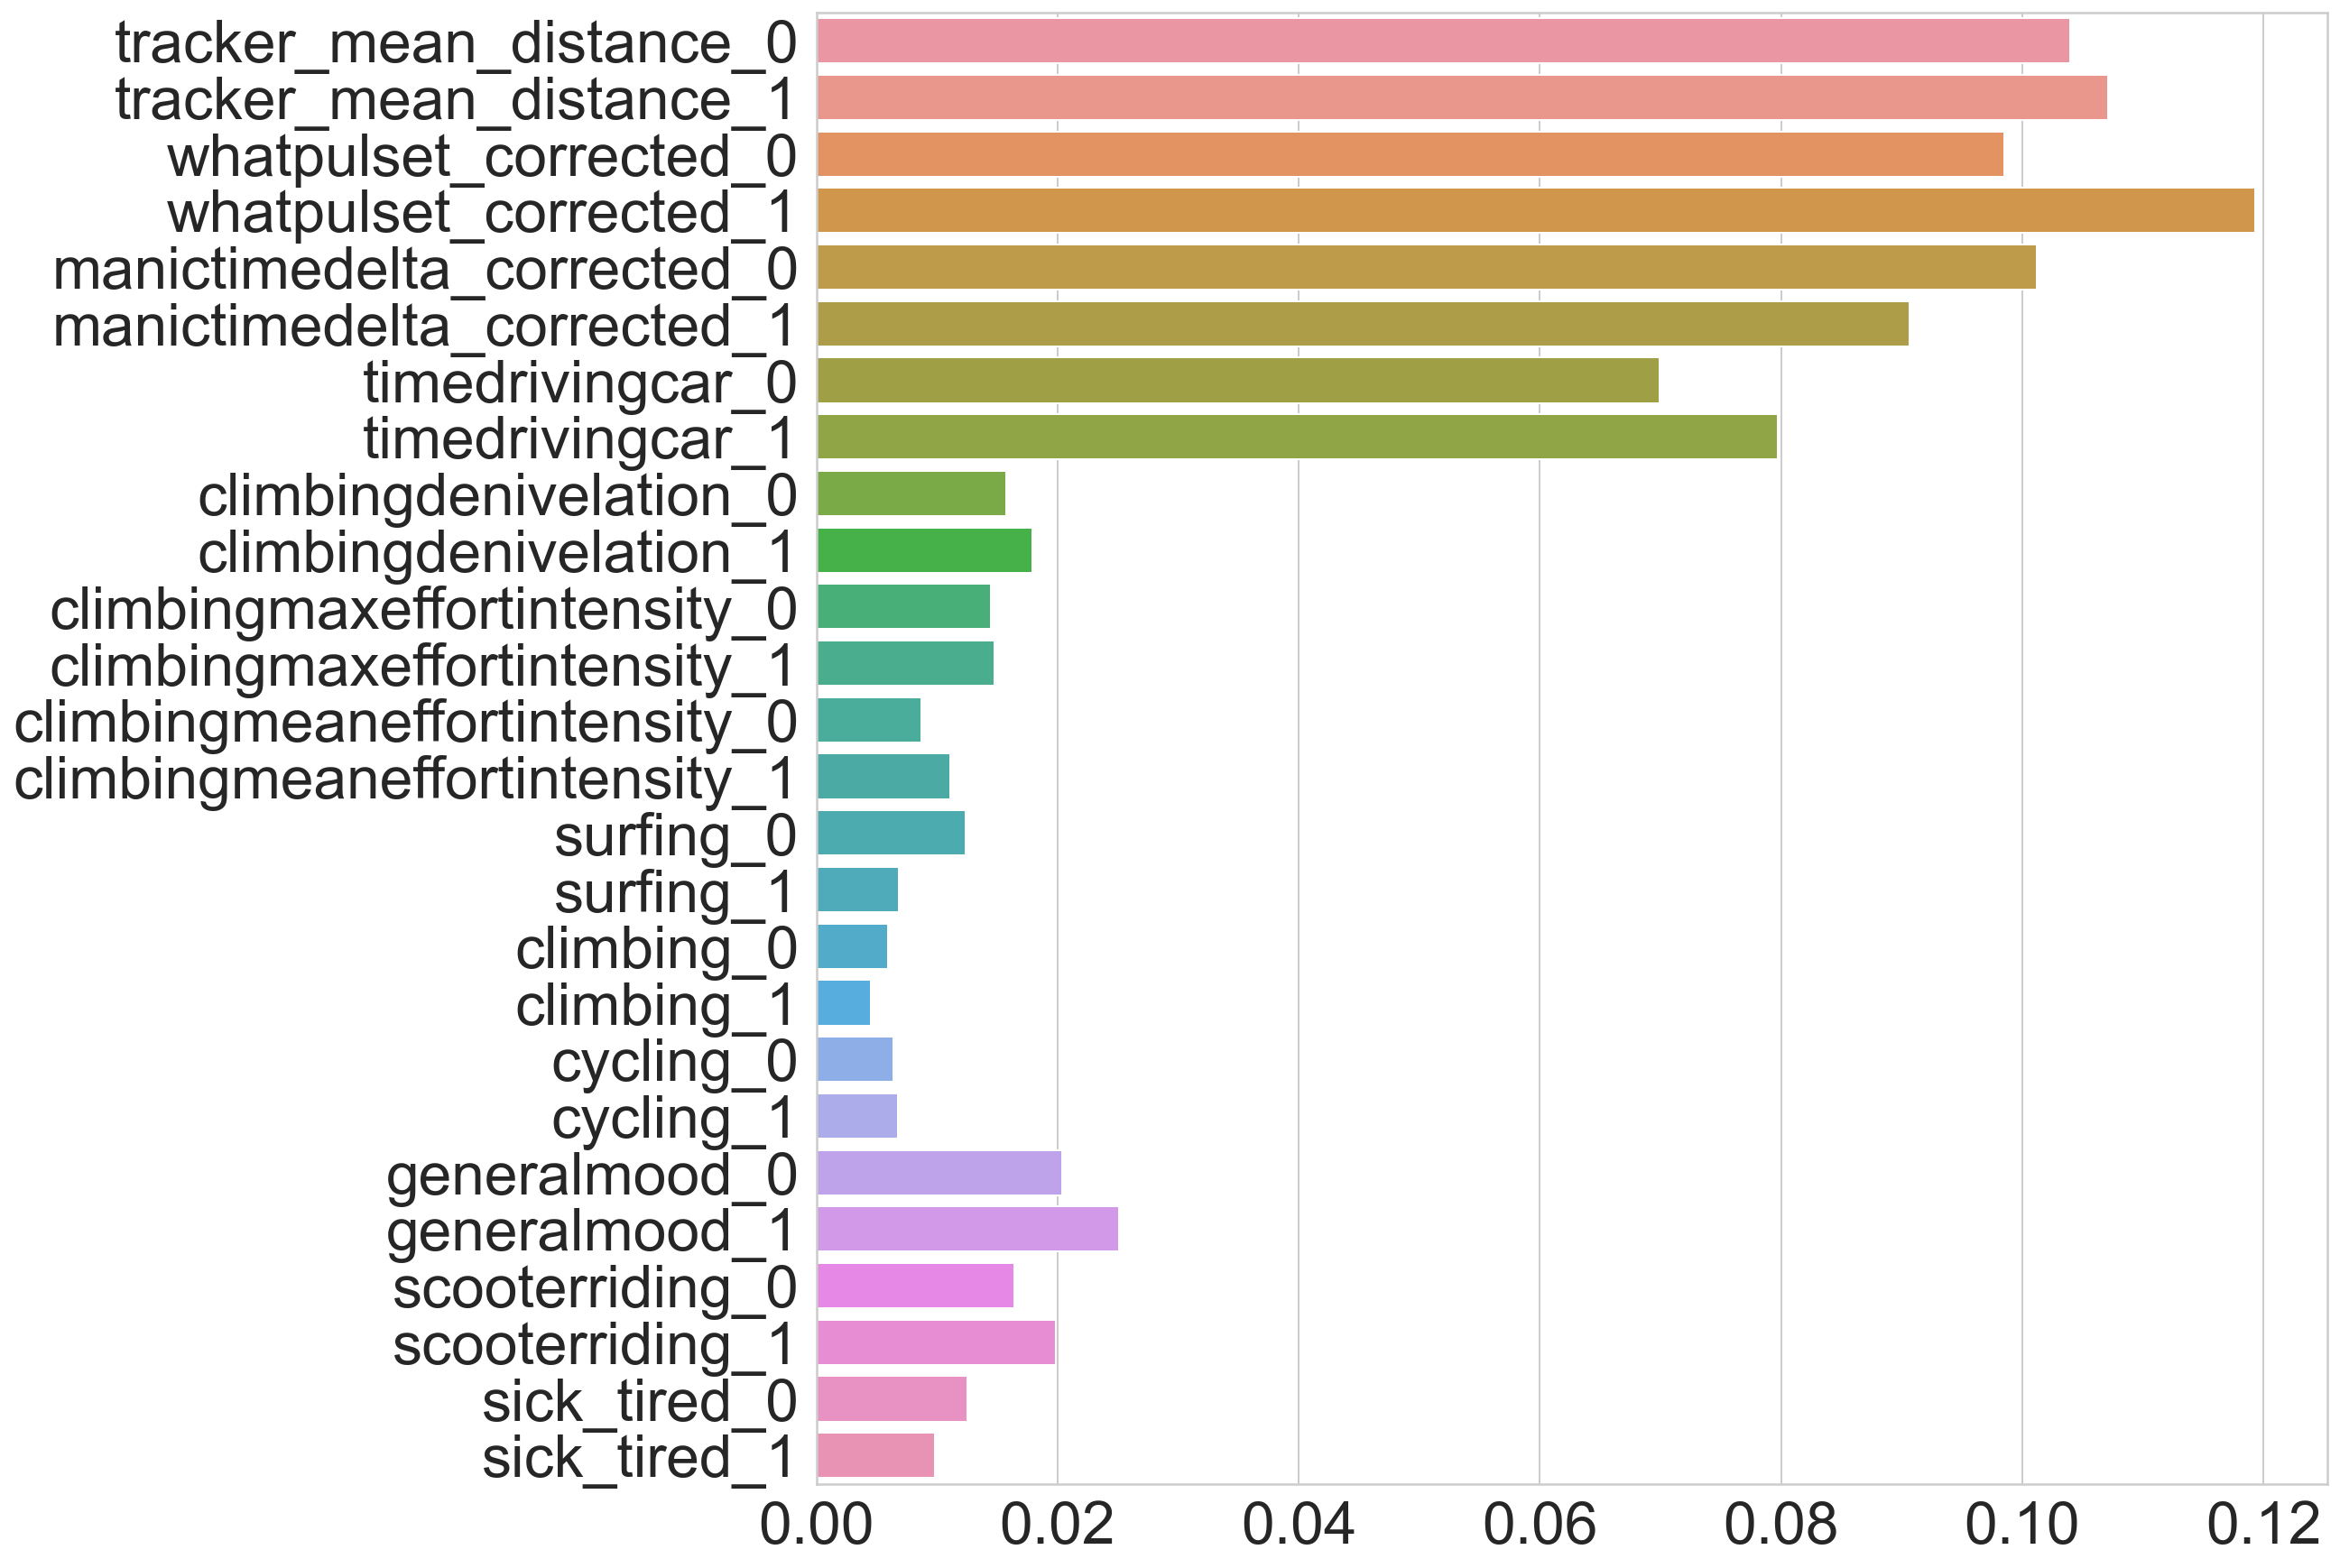

In [715]:
fig,ax = plt.subplots(figsize=(15,15))
sns.barplot(y=X_train.columns,x=search.best_estimator_.feature_importances_,orient='horizontal')

In [839]:
labels = ['No Pain','Pain']

In [716]:
y_val_pred = search.predict(X_val)

In [719]:
from sklearn.metrics import classification_report,confusion_matrix

In [841]:
print(classification_report(y_val,y_val_pred,target_names=labels))

              precision    recall  f1-score   support

     No Pain       0.25      0.18      0.21        22
        Pain       0.59      0.68      0.63        38

    accuracy                           0.50        60
   macro avg       0.42      0.43      0.42        60
weighted avg       0.47      0.50      0.48        60



<AxesSubplot:>

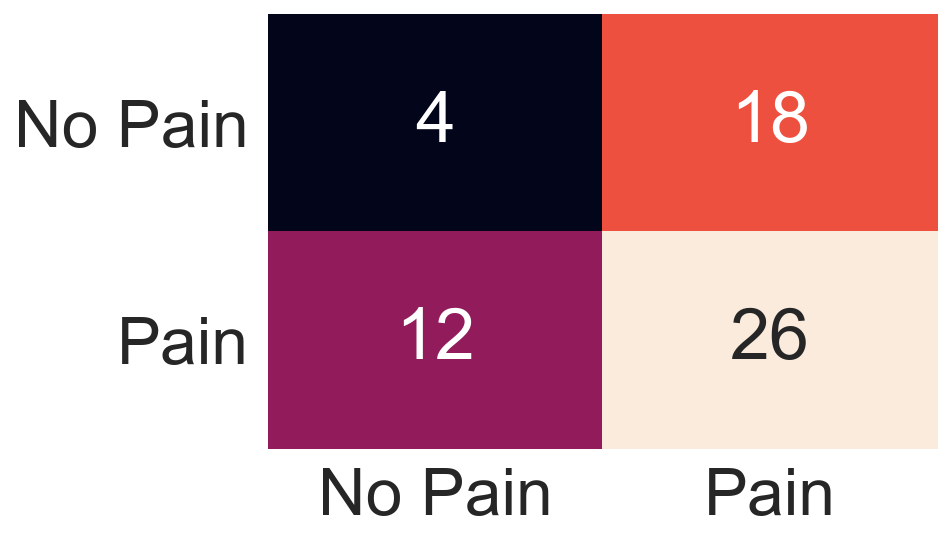

In [804]:
fig,ax = plt.subplots(figsize=(6,4))
sns.heatmap(confusion_matrix(y_val,y_val_pred),annot=True, 
            xticklabels=labels, yticklabels=labels,
            cbar=False
           )

We try to add oversampling of the minority class

In [761]:
y_train.value_counts()

1    148
0     88
Name: pain, dtype: int64

In [727]:
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

In [784]:
param_grid = {
    'smote__k_neighbors':np.arange(3,30,1),
}

In [785]:
pipe = Pipeline([
    ('smote',SMOTE(k_neighbors=20)),
    ('scaler',StandardScaler()),
    ('rf_clf',RandomForestClassifier(n_estimators=180,max_depth=9))
])

In [794]:
search_pipe = GridSearchCV(pipe,param_grid=param_grid,cv=10,return_train_score=True,scoring='f1')

In [795]:
search_pipe.fit(X_train,y_train)

GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('smote', SMOTE(k_neighbors=20)),
                                       ('scaler', StandardScaler()),
                                       ('rf_clf',
                                        RandomForestClassifier(max_depth=9,
                                                               n_estimators=180))]),
             param_grid={'smote__k_neighbors': array([ 3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19,
       20, 21, 22, 23, 24, 25, 26, 27, 28, 29])},
             return_train_score=True, scoring='f1')

In [796]:
search_pipe.best_estimator_

Pipeline(steps=[('smote', SMOTE(k_neighbors=18)), ('scaler', StandardScaler()),
                ('rf_clf',
                 RandomForestClassifier(max_depth=9, n_estimators=180))])

In [797]:
y_val_pred_search_pipe = search_pipe.predict(X_val)

In [798]:
print(classification_report(y_val,y_val_pred_search_pipe,target_names=['No Pain','Pain']))

              precision    recall  f1-score   support

     No Pain       0.32      0.36      0.34        22
        Pain       0.60      0.55      0.58        38

    accuracy                           0.48        60
   macro avg       0.46      0.46      0.46        60
weighted avg       0.50      0.48      0.49        60



In [780]:
pipe.fit(X_train,y_train)

Pipeline(steps=[('smote', SMOTE(k_neighbors=15)), ('scaler', StandardScaler()),
                ('rf_clf',
                 RandomForestClassifier(max_depth=9, n_estimators=180))])

In [781]:
y_val_pred_pipe = pipe.predict(X_val)

In [782]:
print(classification_report(y_val,y_val_pred_pipe,target_names=['No Pain','Pain']))

              precision    recall  f1-score   support

     No Pain       0.36      0.41      0.38        22
        Pain       0.63      0.58      0.60        38

    accuracy                           0.52        60
   macro avg       0.49      0.49      0.49        60
weighted avg       0.53      0.52      0.52        60



<AxesSubplot:>

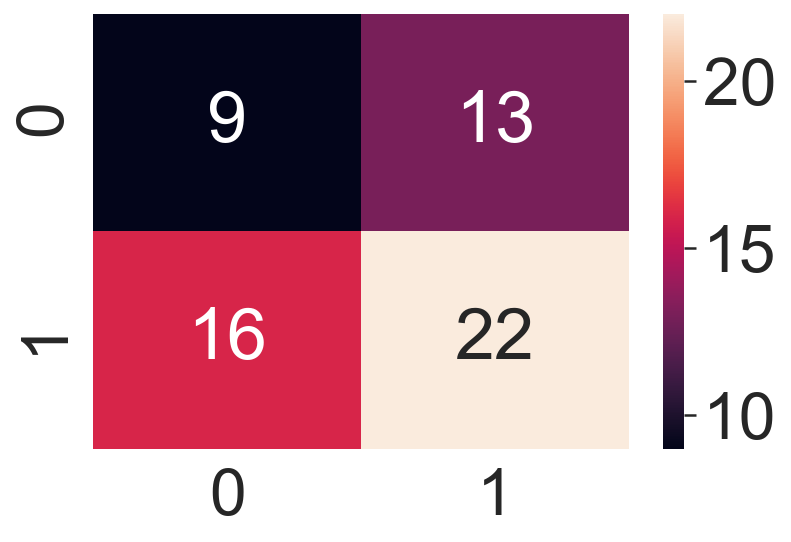

In [801]:
fig,ax = plt.subplots(figsize=(6,4))
sns.heatmap(confusion_matrix(y_val,y_val_pred_pipe),annot=True)